In [1]:
# we edited the ranges of the augmentation initializers 
# didn't perform augmentation on testing images 
# we have the original image with the augmented images for training

In [ ]:
import numpy as np 
import pandas as pd
import os 
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from skimage.util import random_noise
from tqdm import tqdm
import shutil   # for copy labeld files
from IPython.display import display,Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Praper image paths and labels

In [4]:
pd.set_option("display.max_colwidth", None)

In [5]:
data_dirs = ['/kaggle/input/datasets/train/images' ,
            '/kaggle/input/datasets/valid/images']


keys = ['ain', 'al', 'aleff','bb','dal','dha','dhad','fa','gaaf','ghain','ha','haa','jeem','kaaf','khaa','la','laam',
        'meem','nun','ra','saad','seen','sheen','ta','taa','thaa','thal','toot','waw','ya','yaa','zay']

In [6]:
# From the imagePath , you can get the label path 

img_paths = []
class_names = []
label_file_paths = []

for data_dir in data_dirs:
    train_or_valid = data_dir.split('/')[-2]
    
    for img_name in os.listdir(data_dir):
        img_path = os.path.join(data_dir,img_name)
        image_name = img_name.split('.')[0]
        className = image_name.split('_')[-2]
        
        label_file_name = f'{image_name}.txt'
        label_file_path = os.path.join(f'/kaggle/input/datasets/{train_or_valid}/labels' , label_file_name)
        
        # get image path and class name for each image 
        img_paths.append(img_path)
        class_names.append(className)
        label_file_paths.append(label_file_path)
        

In [7]:
df = pd.DataFrame({'path' : img_paths , 'label' : label_file_paths , 'class' : class_names})
df = df.sample(frac=1).reset_index(drop=True)
df

path  \
0      /kaggle/input/datasets/train/images/1014_32_F_aleff_4.jpg   
1       /kaggle/input/datasets/valid/images/1035_18_F_jeem_1.jpg   
2           /kaggle/input/datasets/valid/images/3_55_F_haa_1.jpg   
3       /kaggle/input/datasets/valid/images/1017_35_M_meem_3.jpg   
4       /kaggle/input/datasets/valid/images/1058_69_M_jeem_7.jpg   
...                                                          ...   
14197      /kaggle/input/datasets/train/images/1_21_M_gaaf_4.jpg   
14198    /kaggle/input/datasets/train/images/1057_44_F_dal_8.jpg   
14199   /kaggle/input/datasets/train/images/1009_53_F_jeem_7.jpg   
14200     /kaggle/input/datasets/train/images/319_22_M_nun_1.jpg   
14201    /kaggle/input/datasets/train/images/168_16_F_meem_5.jpg   

                                                           label  class  
0      /kaggle/input/datasets/train/labels/1014_32_F_aleff_4.txt  aleff  
1       /kaggle/input/datasets/valid/labels/1035_18_F_jeem_1.txt   jeem  
2           /kaggle/input/datasets/valid/labels/3_55_F_haa_1.txt    haa  
3       /kaggle/input/datasets/valid/labels/1017_35_M_meem_3.txt   meem  
4       /kaggle/input/datasets/valid/labels/1058_69_M_jeem_7.txt   jeem  
...                                                          ...    ...  
14197      /kaggle/input/datasets/train/labels/1_21_M_gaaf_4.txt   gaaf  
14198    /kaggle/input/datasets/train/labels/1057_44_F_dal_8.txt    dal  
14199   /kaggle/input/datasets/train/labels/1009_53_F_jeem_7.txt   jeem  
14200     /kaggle/input/datasets/train/labels/319_22_M_nun_1.txt    nun  
14201    /kaggle/input/datasets/train/labels/168_16_F_meem_5.txt   meem  

[14202 rows x 3 columns]

In [8]:
df['class'].value_counts()

class
thaa     451
meem     450
la       450
khaa     450
dha      450
ghain    450
al       450
thal     450
sheen    450
ta       450
fa       450
ha       450
seen     450
saad     450
yaa      450
toot     450
haa      449
jeem     448
ain      448
ya       448
bb       447
aleff    447
kaaf     446
taa      444
gaaf     444
zay      440
laam     440
dhad     439
ra       427
nun      421
waw      412
dal      401
Name: count, dtype: int64

# Data Spliting 

In [13]:
def DataFrameSpliting(df , ratio , classesList):
    
    trainDf = pd.DataFrame(columns = ['path','label','class'])
    testDf = pd.DataFrame(columns = ['path','label','class'])
    for clas in classesList :
        tempDf = df[df['class'] == clas]
        lastIndex = int(len(tempDf) * ratio)
        trainClassDf = tempDf[:lastIndex]
        testClassDf = tempDf[lastIndex:]
        trainDf = pd.concat([trainDf , trainClassDf] , axis=0)
        testDf = pd.concat([testDf , testClassDf] , axis=0)
        
    return trainDf.sample(frac=1).reset_index(drop=True) , testDf.sample(frac=1).reset_index(drop=True)  # shuffling , reset index

In [14]:
classList = list(df['class'].unique())
train_df , test_df = DataFrameSpliting(df , 0.70 , classList)

In [15]:
len(train_df) ,len(test_df)

(9932, 4270)

# Data Augmentation (4 types)

In [16]:
# Define augmentation pipelines
light_pipeline = A.Compose([A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(0.1, 0.3), p=0.6)])
gaussian_noise_pipeline = A.Compose([A.GaussNoise(var_limit=(50, 200), p=0.5)])
blur_pipeline = A.Compose([A.Blur(blur_limit=(3,5), p=0.5)])

In [17]:
# !rm -rf /kaggle/working/*

In [18]:
# The structure of yaml file for YOLO model 
# /dataset
#     ├── train
#     │   ├── images
#     │   │   ├── image_001.jpg
#     │   │   ├── image_002.jpg
#     │   │   └── ...
#     │   └── labels
#     │       ├── image_001.txt
#     │       ├── image_002.txt
#     │       └── ...
#     └── valid
#         ├── images
#         │   ├── image_101.jpg
#         │   ├── image_102.jpg
#         │   └── ...
#         └── labels
#             ├── image_101.txt
#             ├── image_102.txt
#             └── ...

In [19]:
# create a folder structure which is sutable with YOLO yaml file (like above cell) 
os.makedirs('/kaggle/working/datasets/train/images')
os.makedirs('/kaggle/working/datasets/train/labels')

os.makedirs('/kaggle/working/datasets/valid/images')
os.makedirs('/kaggle/working/datasets/valid/labels')

In [20]:
# applay data augmentation on training data , save augmented images and also the original images and it's labels
train_images_path = '/kaggle/working/datasets/train/images'

for img_path, class_name, label_file_path in tqdm(zip(train_df['path'], train_df['class'] , train_df['label']) , total = len(train_df)):
    img_name = img_path.split('/')[-1].split('.')[0]
        
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # salt & pepper noise
    img_sp = random_noise(image, mode='s&p', amount = 0.04)
    img_sp = 255 * img_sp
    img_sp = img_sp.astype('uint8')
    
    # Apply augmentations
    augmented_light = light_pipeline(image=image)['image']
    augmented_gaussian_noise = gaussian_noise_pipeline(image=image)['image']
    augmented_blur = blur_pipeline(image=image)['image']
    
    # Save augmented images 
    cv2.imwrite(os.path.join(train_images_path, f'light_{img_name}.jpg'), cv2.cvtColor(augmented_light, cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(train_images_path, f'gaussian_{img_name}.jpg'), cv2.cvtColor(augmented_gaussian_noise, cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(train_images_path, f'blur_{img_name}.jpg'), cv2.cvtColor(augmented_blur, cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(train_images_path, f's&p_{img_name}.jpg'), cv2.cvtColor(img_sp, cv2.COLOR_RGB2BGR))
    shutil.copy(img_path , os.path.join(train_images_path, f'original_{img_name}.jpg'))    # also we get the original image
    
    aug_list = ['light', 'gaussian', 'blur', 's&p' , 'original']
    for aug in aug_list: # save the annotated files 
        aug_label_name = f'{aug}_{img_name}.txt'
        shutil.copy(label_file_path , os.path.join('/kaggle/working/datasets/train/labels', aug_label_name))

100%|██████████| 9932/9932 [09:02<00:00, 18.32it/s]


In [21]:
len(os.listdir('/kaggle/working/datasets/train/labels'))  , len(os.listdir('/kaggle/working/datasets/train/images'))

(49660, 49660)

In [22]:
# Copy both validation images and it's annotations to a new directory without augmentation 

valid_images_path = '/kaggle/working/datasets/valid/images'

for img_path, class_name, label_file_path in tqdm(zip(test_df['path'], test_df['class'] , test_df['label']) , total = len(test_df)):
    img_name = img_path.split('/')[-1].split('.')[0]
    # only copy the image to the new directory 
    shutil.copy(img_path , os.path.join(valid_images_path, f'original_{img_name}.jpg'))
    shutil.copy(label_file_path , os.path.join('/kaggle/working/datasets/valid/labels', f'original_{img_name}.txt'))

100%|██████████| 4270/4270 [00:55<00:00, 76.92it/s]


In [23]:
len(os.listdir('/kaggle/working/datasets/valid/labels'))  , len(os.listdir('/kaggle/working/datasets/valid/images'))

(4270, 4270)

# Edit yaml file with correct images and labels path 

In [24]:
with open('/kaggle/input/datasets/sign.yaml', 'r') as file:
    yaml_content = yaml.safe_load(file)

yaml_content['train'] = '/kaggle/working/datasets/train/images'
yaml_content['val'] = '/kaggle/working/datasets/valid/images'

with open('/kaggle/working/datasets/edited_sign.yaml', 'w') as file:
    yaml.dump(yaml_content, file)

In [25]:
with open('/kaggle/working/datasets/edited_sign.yaml', 'r') as file:
    yaml_content = yaml.safe_load(file)
yaml_content

{'names': ['ain',
  'al',
  'aleff',
  'bb',
  'dal',
  'dha',
  'dhad',
  'fa',
  'gaaf',
  'ghain',
  'ha',
  'haa',
  'jeem',
  'kaaf',
  'khaa',
  'la',
  'laam',
  'meem',
  'nun',
  'ra',
  'saad',
  'seen',
  'sheen',
  'ta',
  'taa',
  'thaa',
  'thal',
  'toot',
  'waw',
  'ya',
  'yaa',
  'zay'],
 'nc': 32,
 'train': '/kaggle/working/datasets/train/images',
 'val': '/kaggle/working/datasets/valid/images'}

# Show some augmented images 

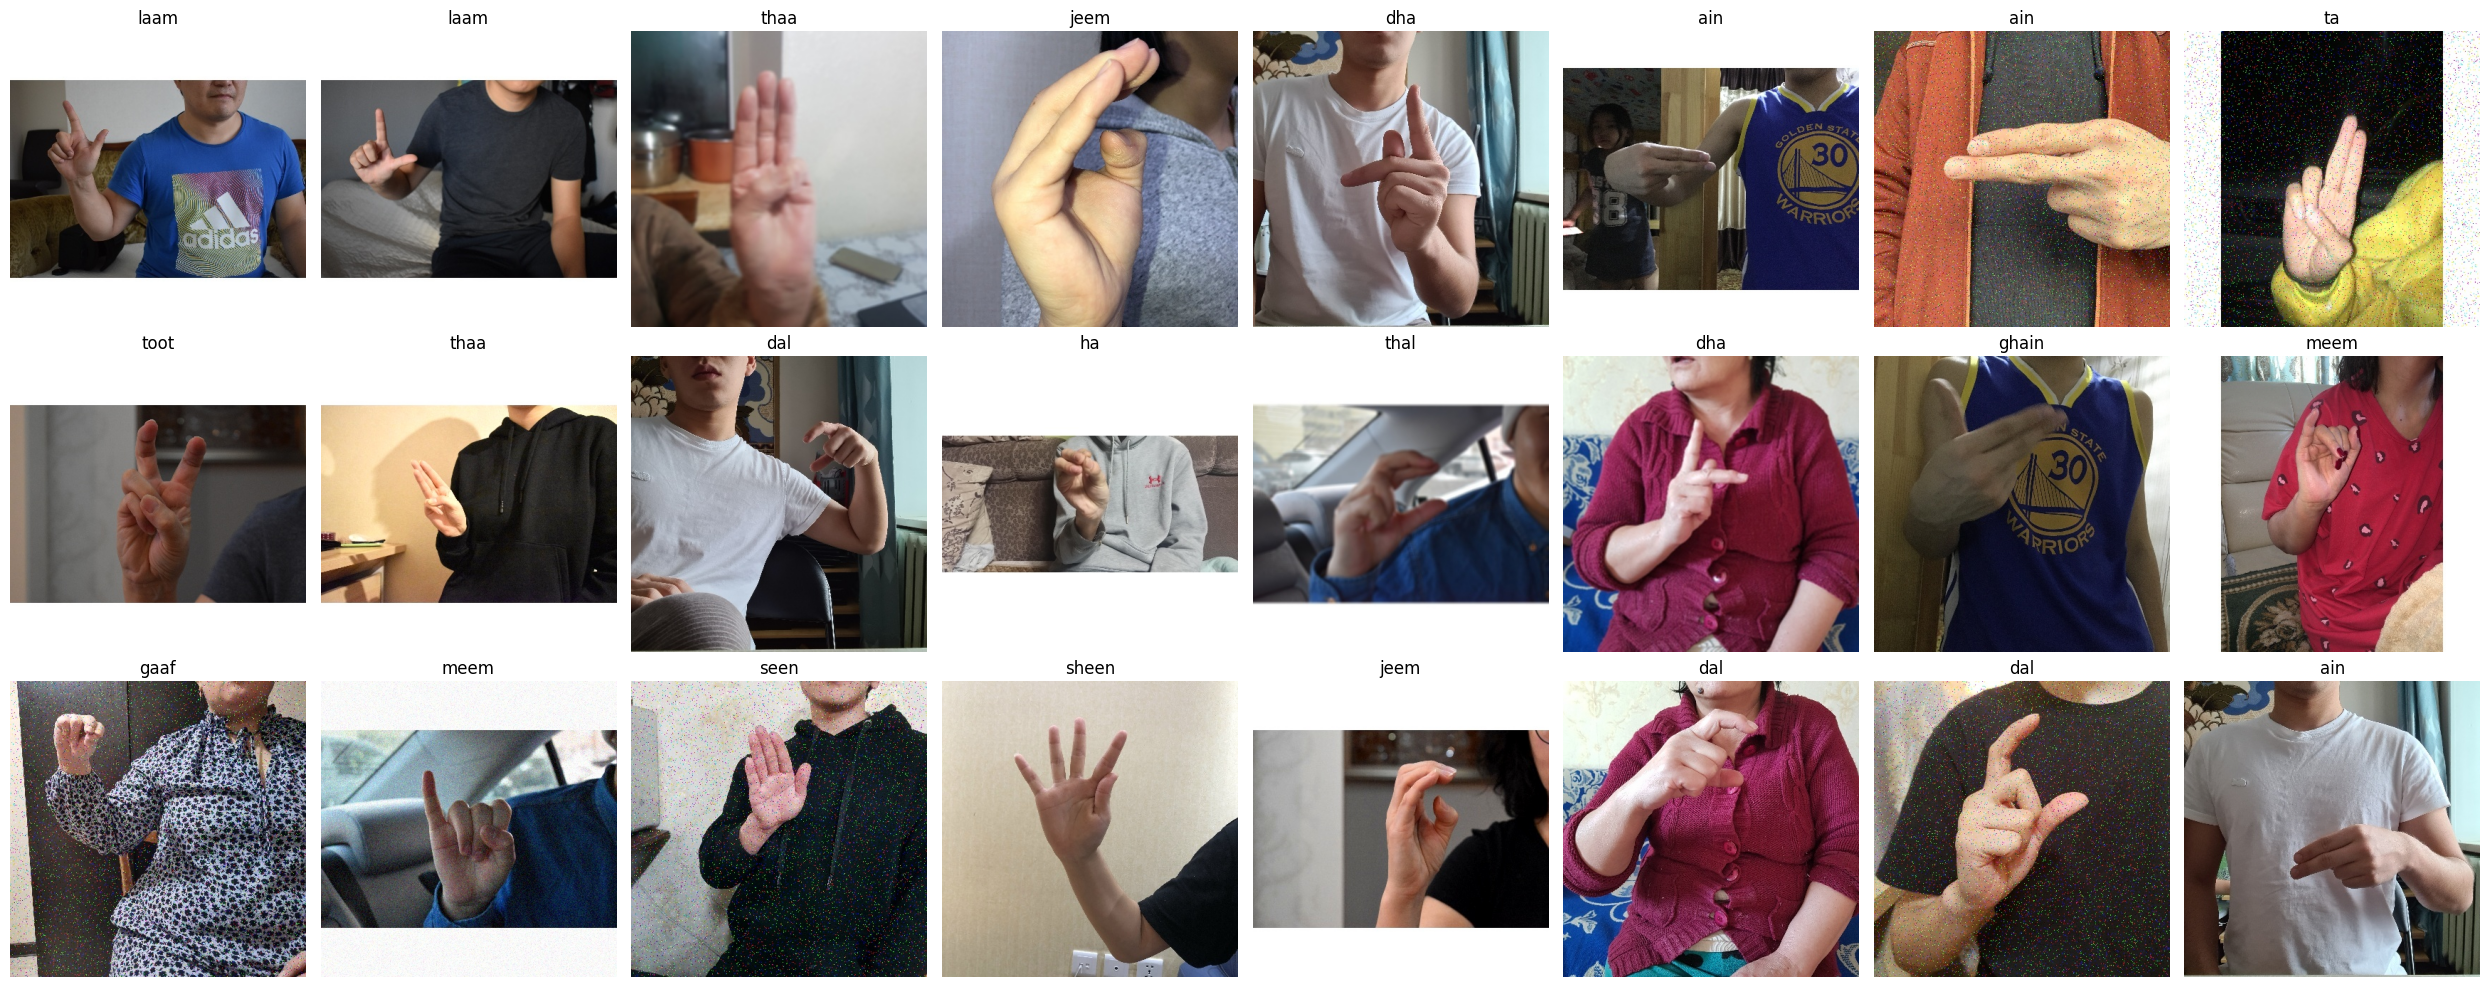

In [26]:
img_names = os.listdir(train_images_path)[:24]
fig, axs = plt.subplots(3, 8, figsize=(25, 10))

axs = axs.flatten()

for ax,img_name in zip(axs , img_names):
    imp_path = os.path.join(train_images_path , img_name)
    label = str(img_name).split('_')[-2]   # extract label of an imgae from a path 
    img = cv2.imread(imp_path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

# Train YOLOv10 model 

In [27]:
yolov10 = YOLO('yolov10m.pt')

100%|██████████| 32.1M/32.1M [00:00<00:00, 83.9MB/s]


In [28]:
%env WANDB_MODE=disabled
amp=False   # faster training times and lower memory usage

env: WANDB_MODE=disabled


In [29]:
yolov10.train(data='/kaggle/working/datasets/edited_sign.yaml' , epochs=12 , imgsz=320 , batch=128 , patience=3 ,plots=True ,save=True, device=0)

Ultralytics 8.3.6 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov10m.pt, data=/kaggle/working/datasets/edited_sign.yaml, epochs=12, time=None, patience=3, batch=128, imgsz=320, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

100%|██████████| 755k/755k [00:00<00:00, 38.2MB/s]
2024-10-07 14:42:44,204	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-07 14:42:44,755	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=32

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1     78720  ultralytics.nn.modules.block.SCDown          [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1    228672  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 157MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/train/labels... 49660 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49660/49660 [00:44<00:00, 1125.67it/s]


train: New cache created: /kaggle/working/datasets/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/valid/labels... 4270 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4270/4270 [00:04<00:00, 1020.83it/s]


val: New cache created: /kaggle/working/datasets/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000278, momentum=0.9) with parameter groups 129 weight(decay=0.0), 142 weight(decay=0.001), 141 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 12 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/12      16.3G      1.716      5.131      2.302        237        320: 100%|██████████| 388/388 [09:29<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:26<00:00,  1.53s/it]

                   all       4270       4273      0.818      0.853      0.913      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/12      16.6G      1.577      2.334      2.197        223        320: 100%|██████████| 388/388 [09:30<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:24<00:00,  1.45s/it]

                   all       4270       4273      0.864      0.857      0.934      0.801


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/12      16.6G      1.217      1.148      1.945        124        320: 100%|██████████| 388/388 [09:30<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:24<00:00,  1.43s/it]

                   all       4270       4273      0.831      0.823      0.899      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/12      16.6G      1.154     0.9151      1.902        124        320: 100%|██████████| 388/388 [09:29<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:24<00:00,  1.42s/it]

                   all       4270       4273       0.91      0.904      0.962      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/12      16.6G      1.069     0.7395      1.856        124        320: 100%|██████████| 388/388 [09:29<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:23<00:00,  1.41s/it]

                   all       4270       4273      0.939      0.934      0.979      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/12      16.6G      1.006     0.6407       1.82        124        320: 100%|██████████| 388/388 [09:29<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:23<00:00,  1.41s/it]

                   all       4270       4273      0.943      0.939      0.981      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/12      16.6G     0.9504     0.5497      1.793        123        320: 100%|██████████| 388/388 [09:29<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:23<00:00,  1.41s/it]

                   all       4270       4273      0.953      0.949      0.982      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/12      16.6G     0.8988     0.4912      1.766        124        320: 100%|██████████| 388/388 [09:29<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:23<00:00,  1.40s/it]

                   all       4270       4273       0.96      0.958      0.986      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/12      16.6G     0.8511     0.4414      1.746        124        320: 100%|██████████| 388/388 [09:29<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:23<00:00,  1.39s/it]

                   all       4270       4273      0.967      0.969      0.989      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/12      16.6G     0.8027     0.3903      1.728        124        320: 100%|██████████| 388/388 [09:28<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:23<00:00,  1.39s/it]

                   all       4270       4273      0.976      0.968      0.989       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/12      16.6G     0.7588     0.3558      1.707        124        320: 100%|██████████| 388/388 [09:29<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:23<00:00,  1.39s/it]

                   all       4270       4273      0.977      0.973      0.991      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/12      16.6G     0.7103      0.322      1.688        124        320: 100%|██████████| 388/388 [09:29<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:23<00:00,  1.39s/it]

                   all       4270       4273      0.977      0.982      0.991      0.917



12 epochs completed in 1.990 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 33.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 33.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.6 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10m summary (fused): 369 layers, 16,487,440 parameters, 0 gradients, 63.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:26<00:00,  1.53s/it]


                   all       4270       4273      0.976      0.983      0.991      0.917
                   ain        135        135      0.961      0.985      0.994      0.908
                    al        135        135      0.986      0.993      0.995      0.945
                 aleff        135        137      0.986      0.994      0.991      0.928
                    bb        135        135      0.929      0.978      0.986      0.932
                   dal        121        122      0.982      0.959       0.98      0.884
                   dha        135        135      0.993      0.978      0.994       0.93
                  dhad        132        132      0.993      0.977      0.995      0.921
                    fa        135        135      0.977      0.965      0.985      0.892
                  gaaf        134        134      0.948      0.948      0.972      0.897
                 ghain        135        135      0.993      0.993      0.995      0.942
                    h

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d2c641b0af0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,

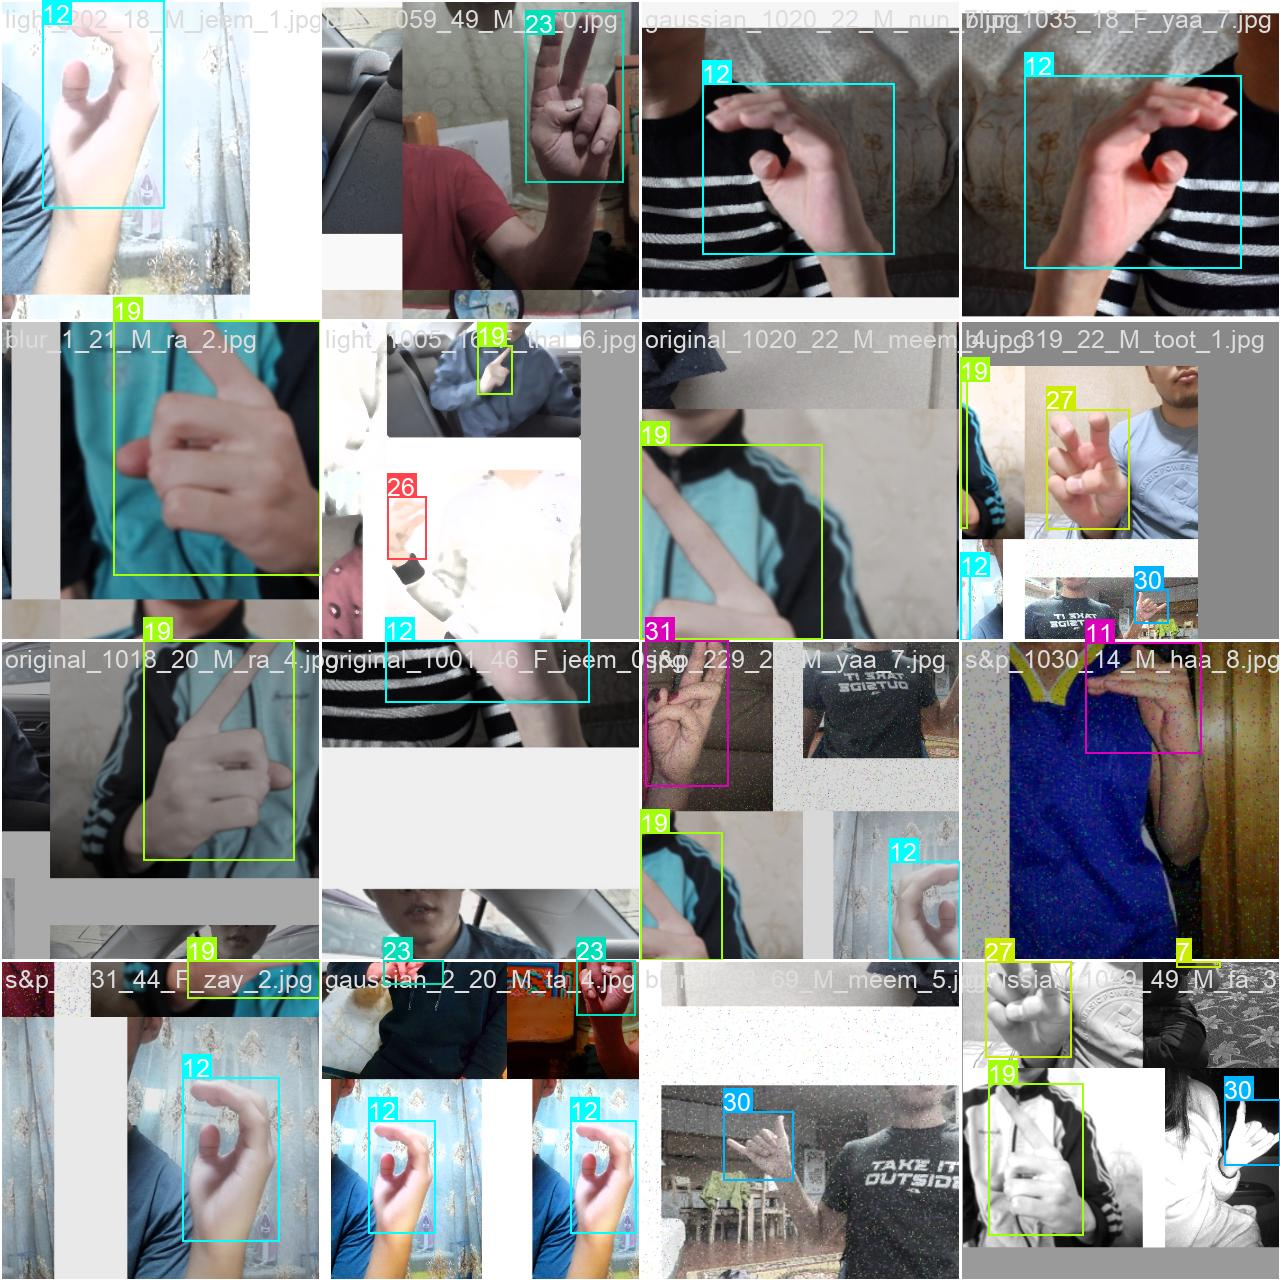

In [30]:
display(Image(filename='/kaggle/working/runs/detect/train/train_batch2.jpg'))

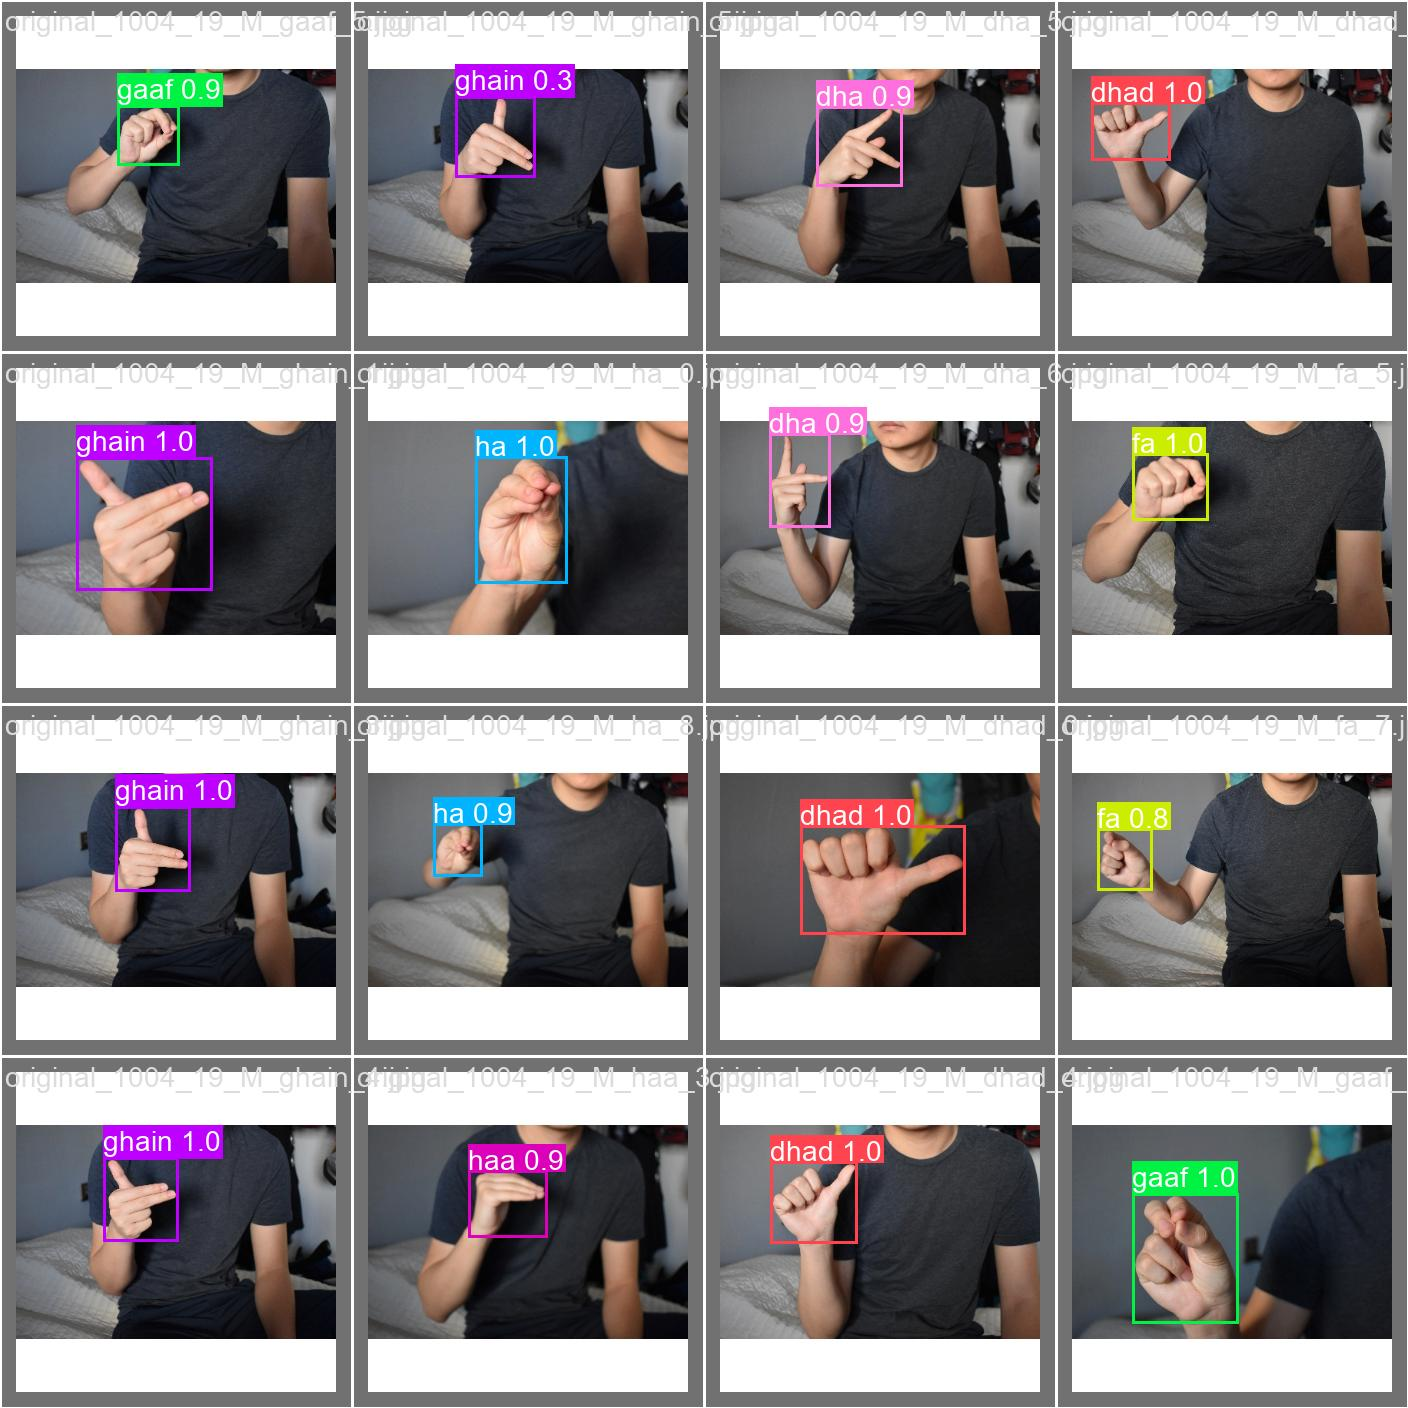

In [31]:
display(Image(filename='/kaggle/working/runs/detect/train/val_batch1_pred.jpg'))

# Evaluation

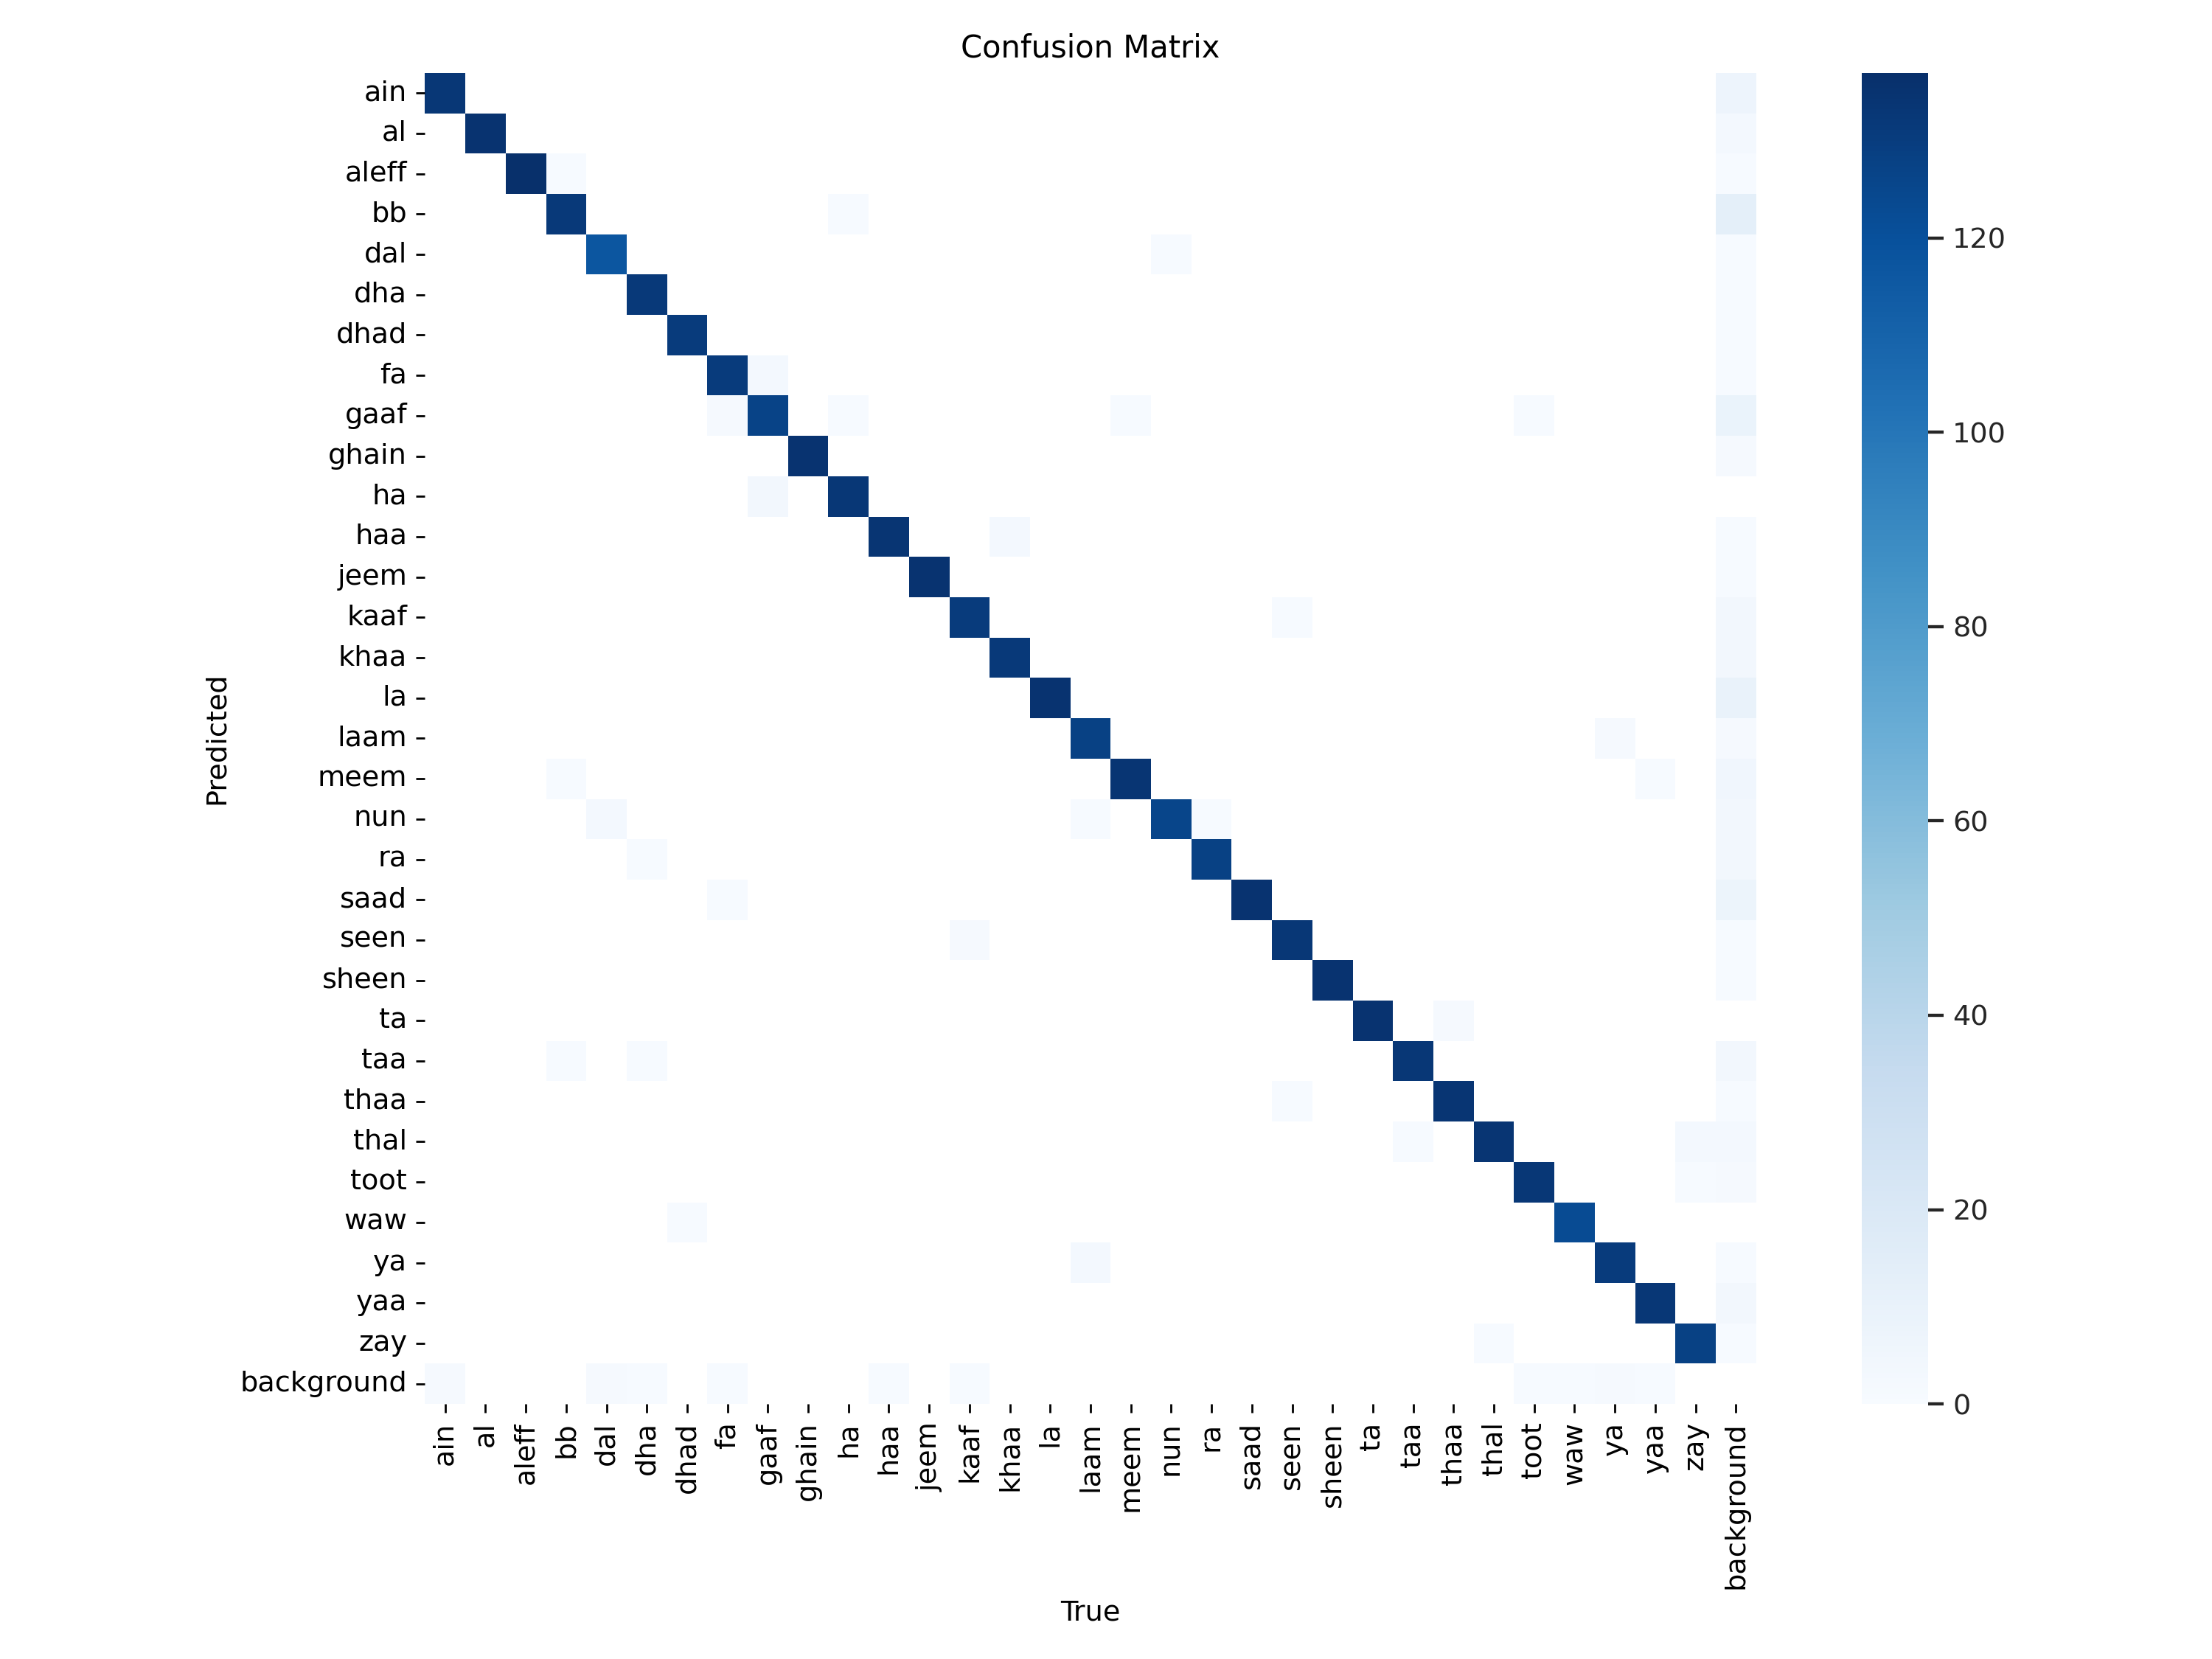

In [32]:
display(Image(filename='/kaggle/working/runs/detect/train/confusion_matrix.png'))

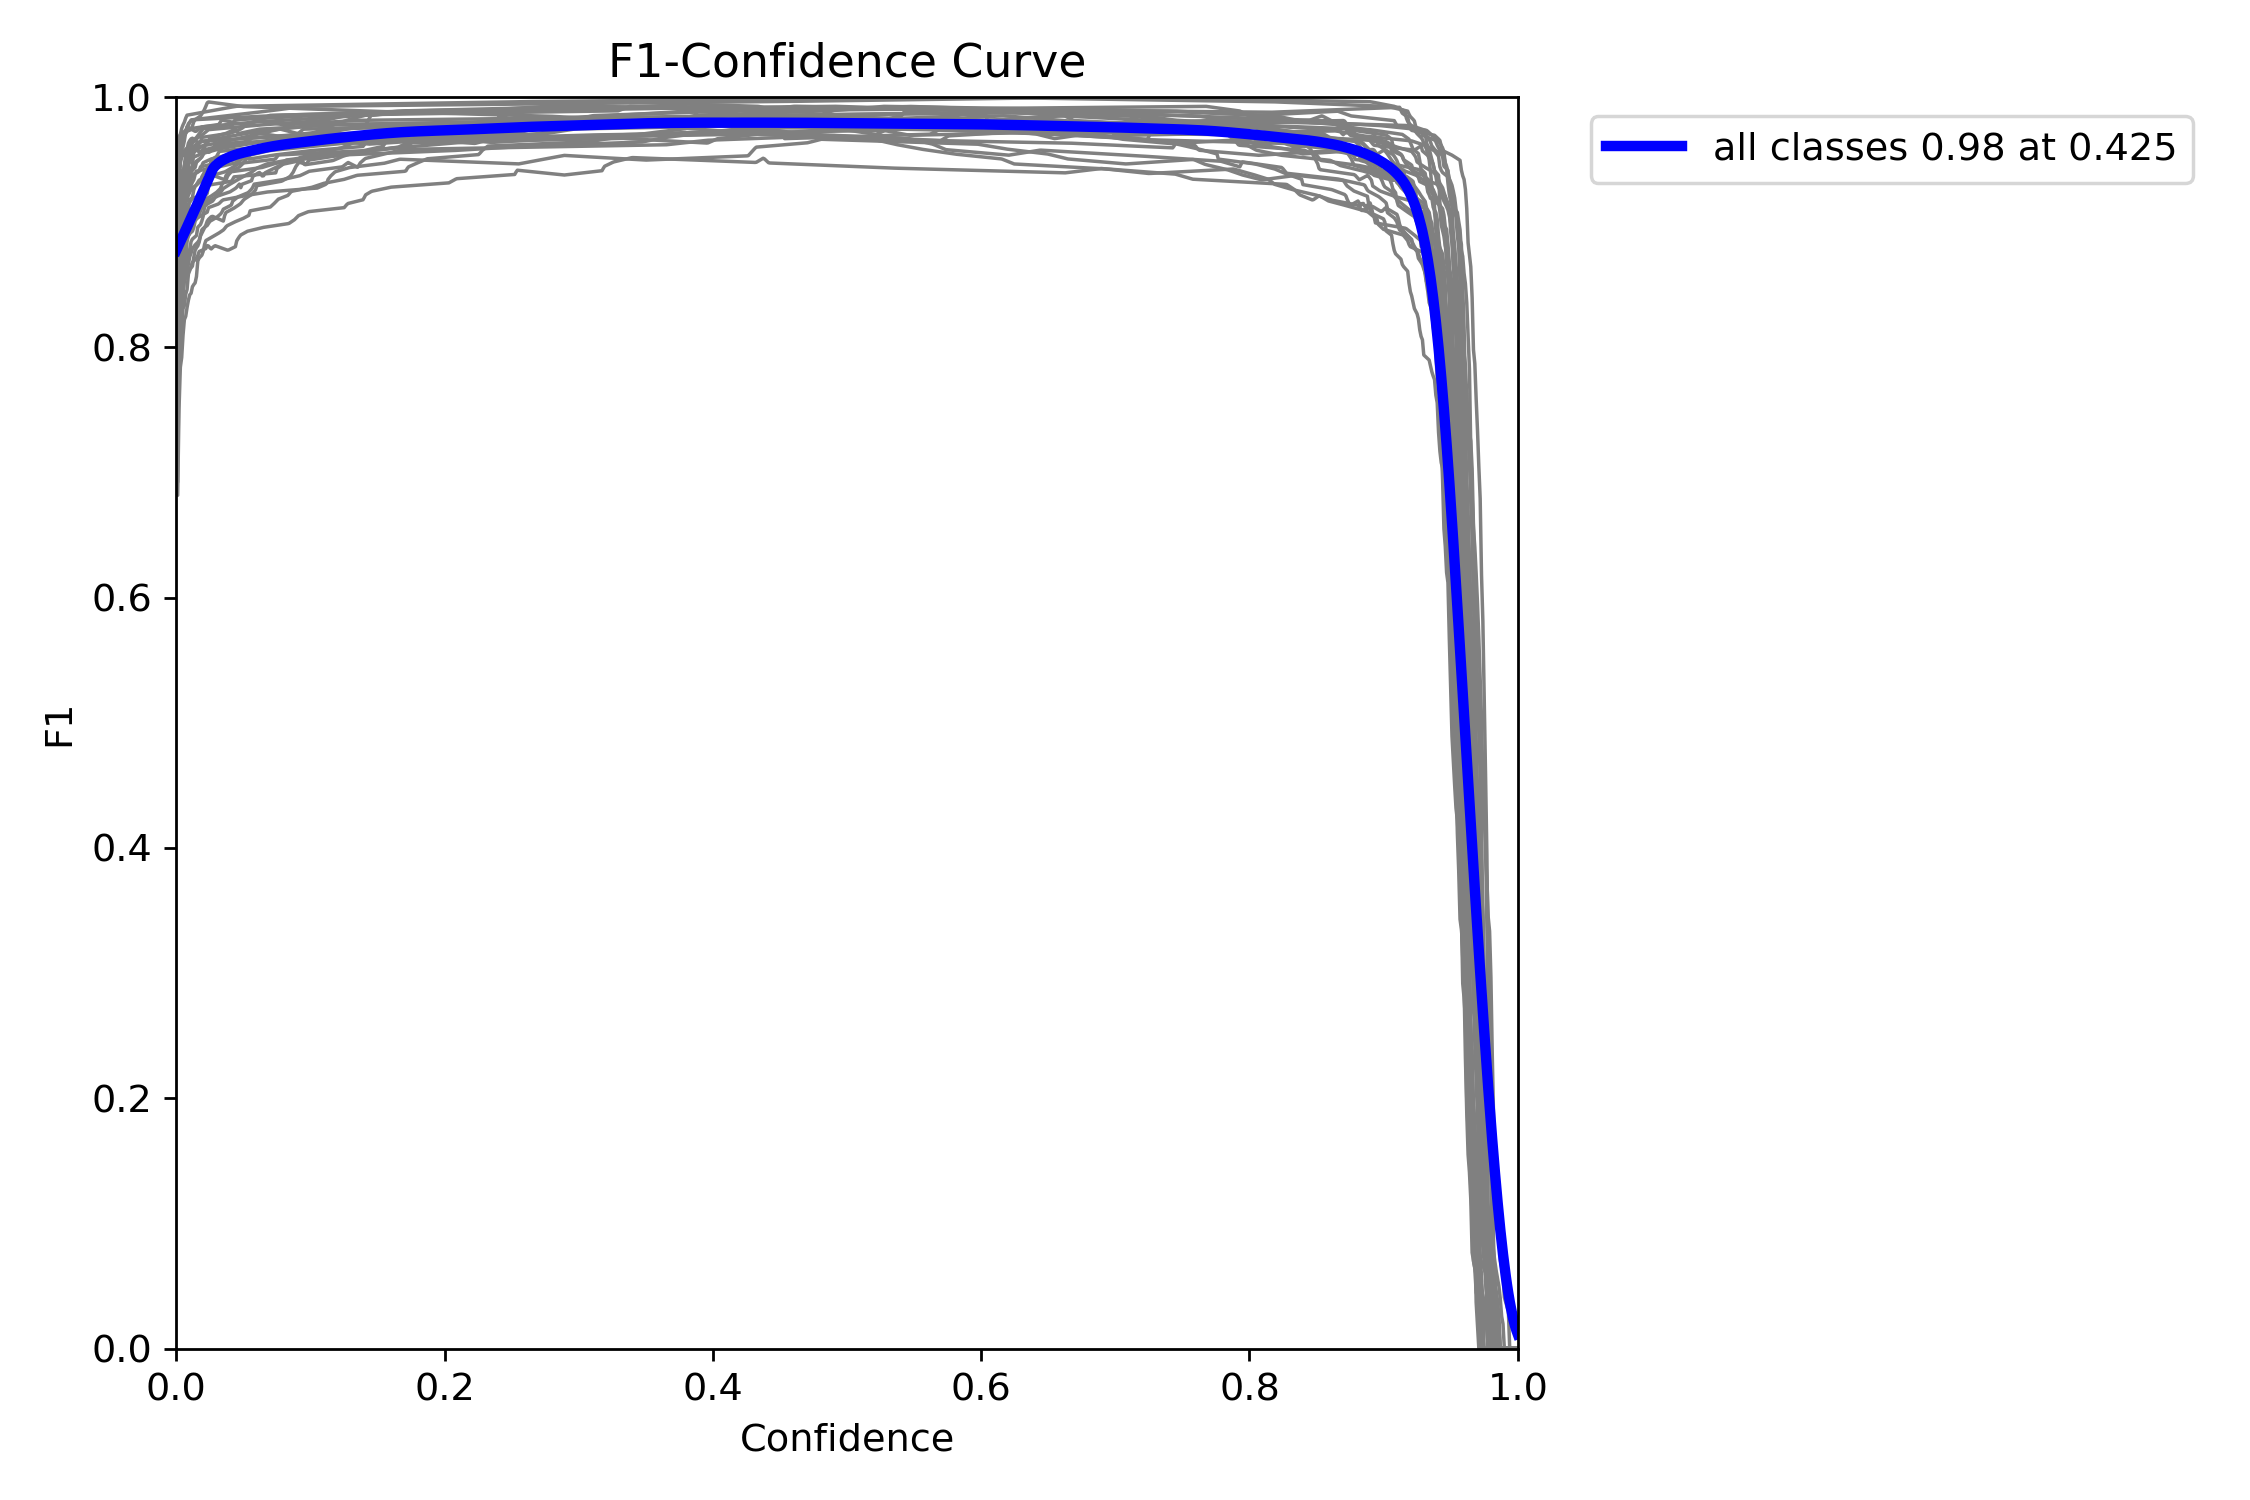

In [33]:
display(Image(filename='/kaggle/working/runs/detect/train/F1_curve.png'))

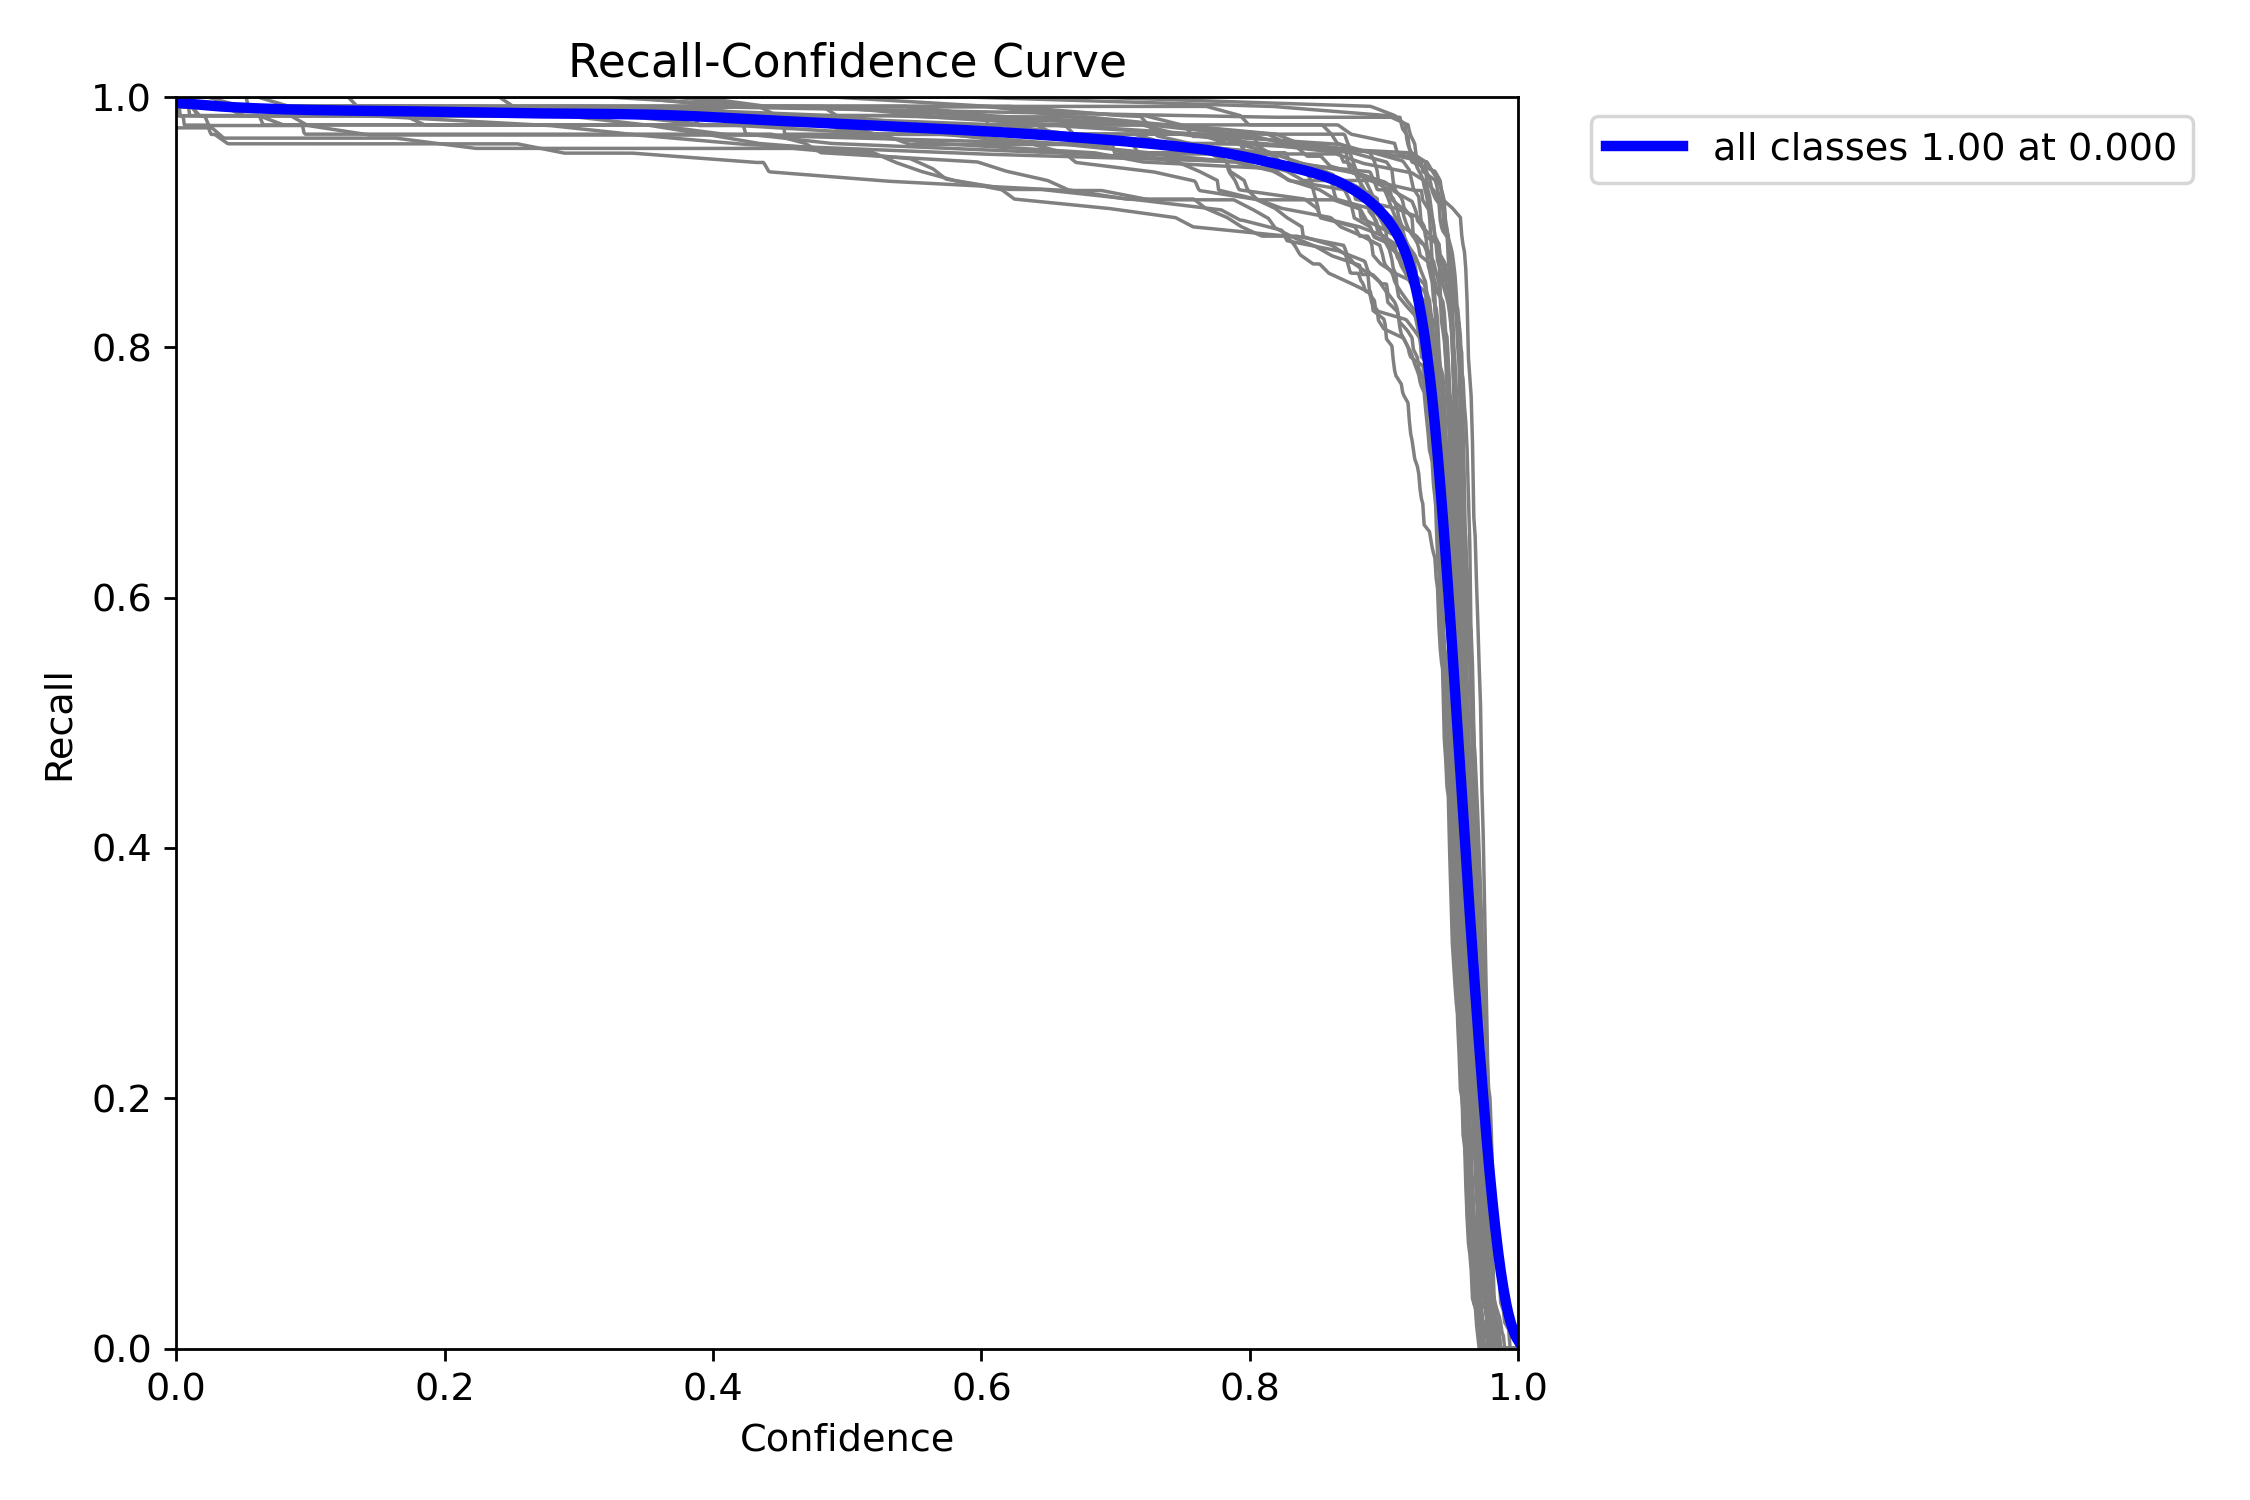

In [34]:
display(Image(filename='/kaggle/working/runs/detect/train/R_curve.png'))

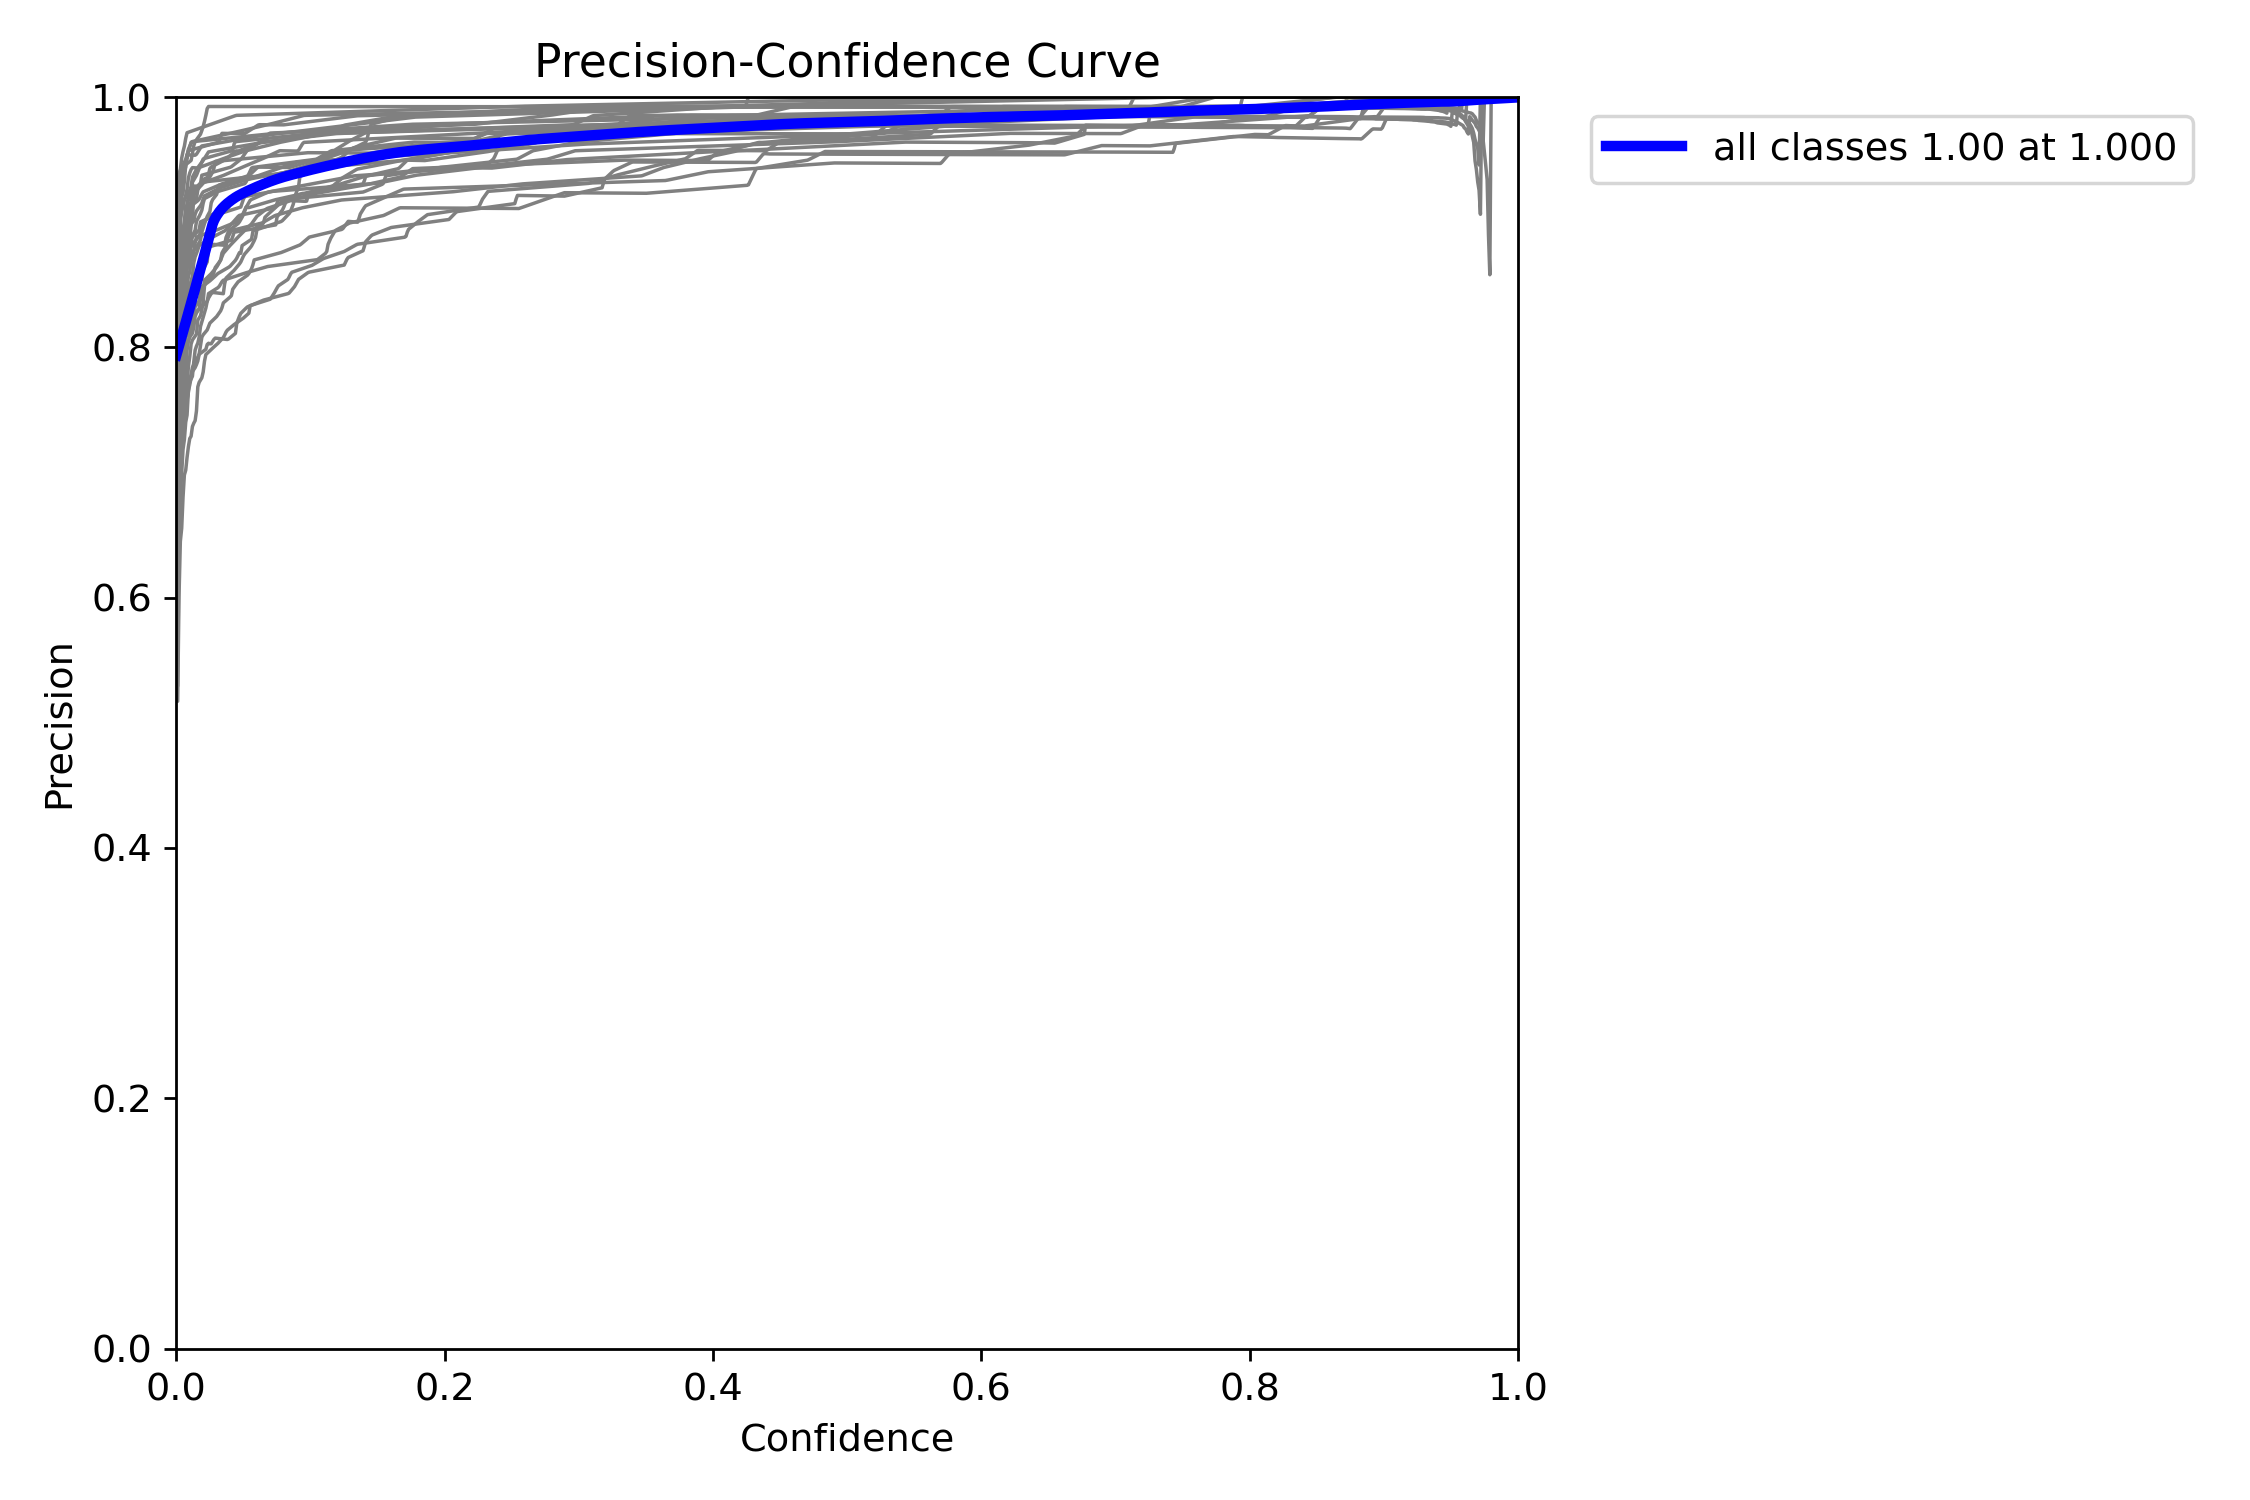

In [35]:
display(Image(filename='/kaggle/working/runs/detect/train/P_curve.png'))


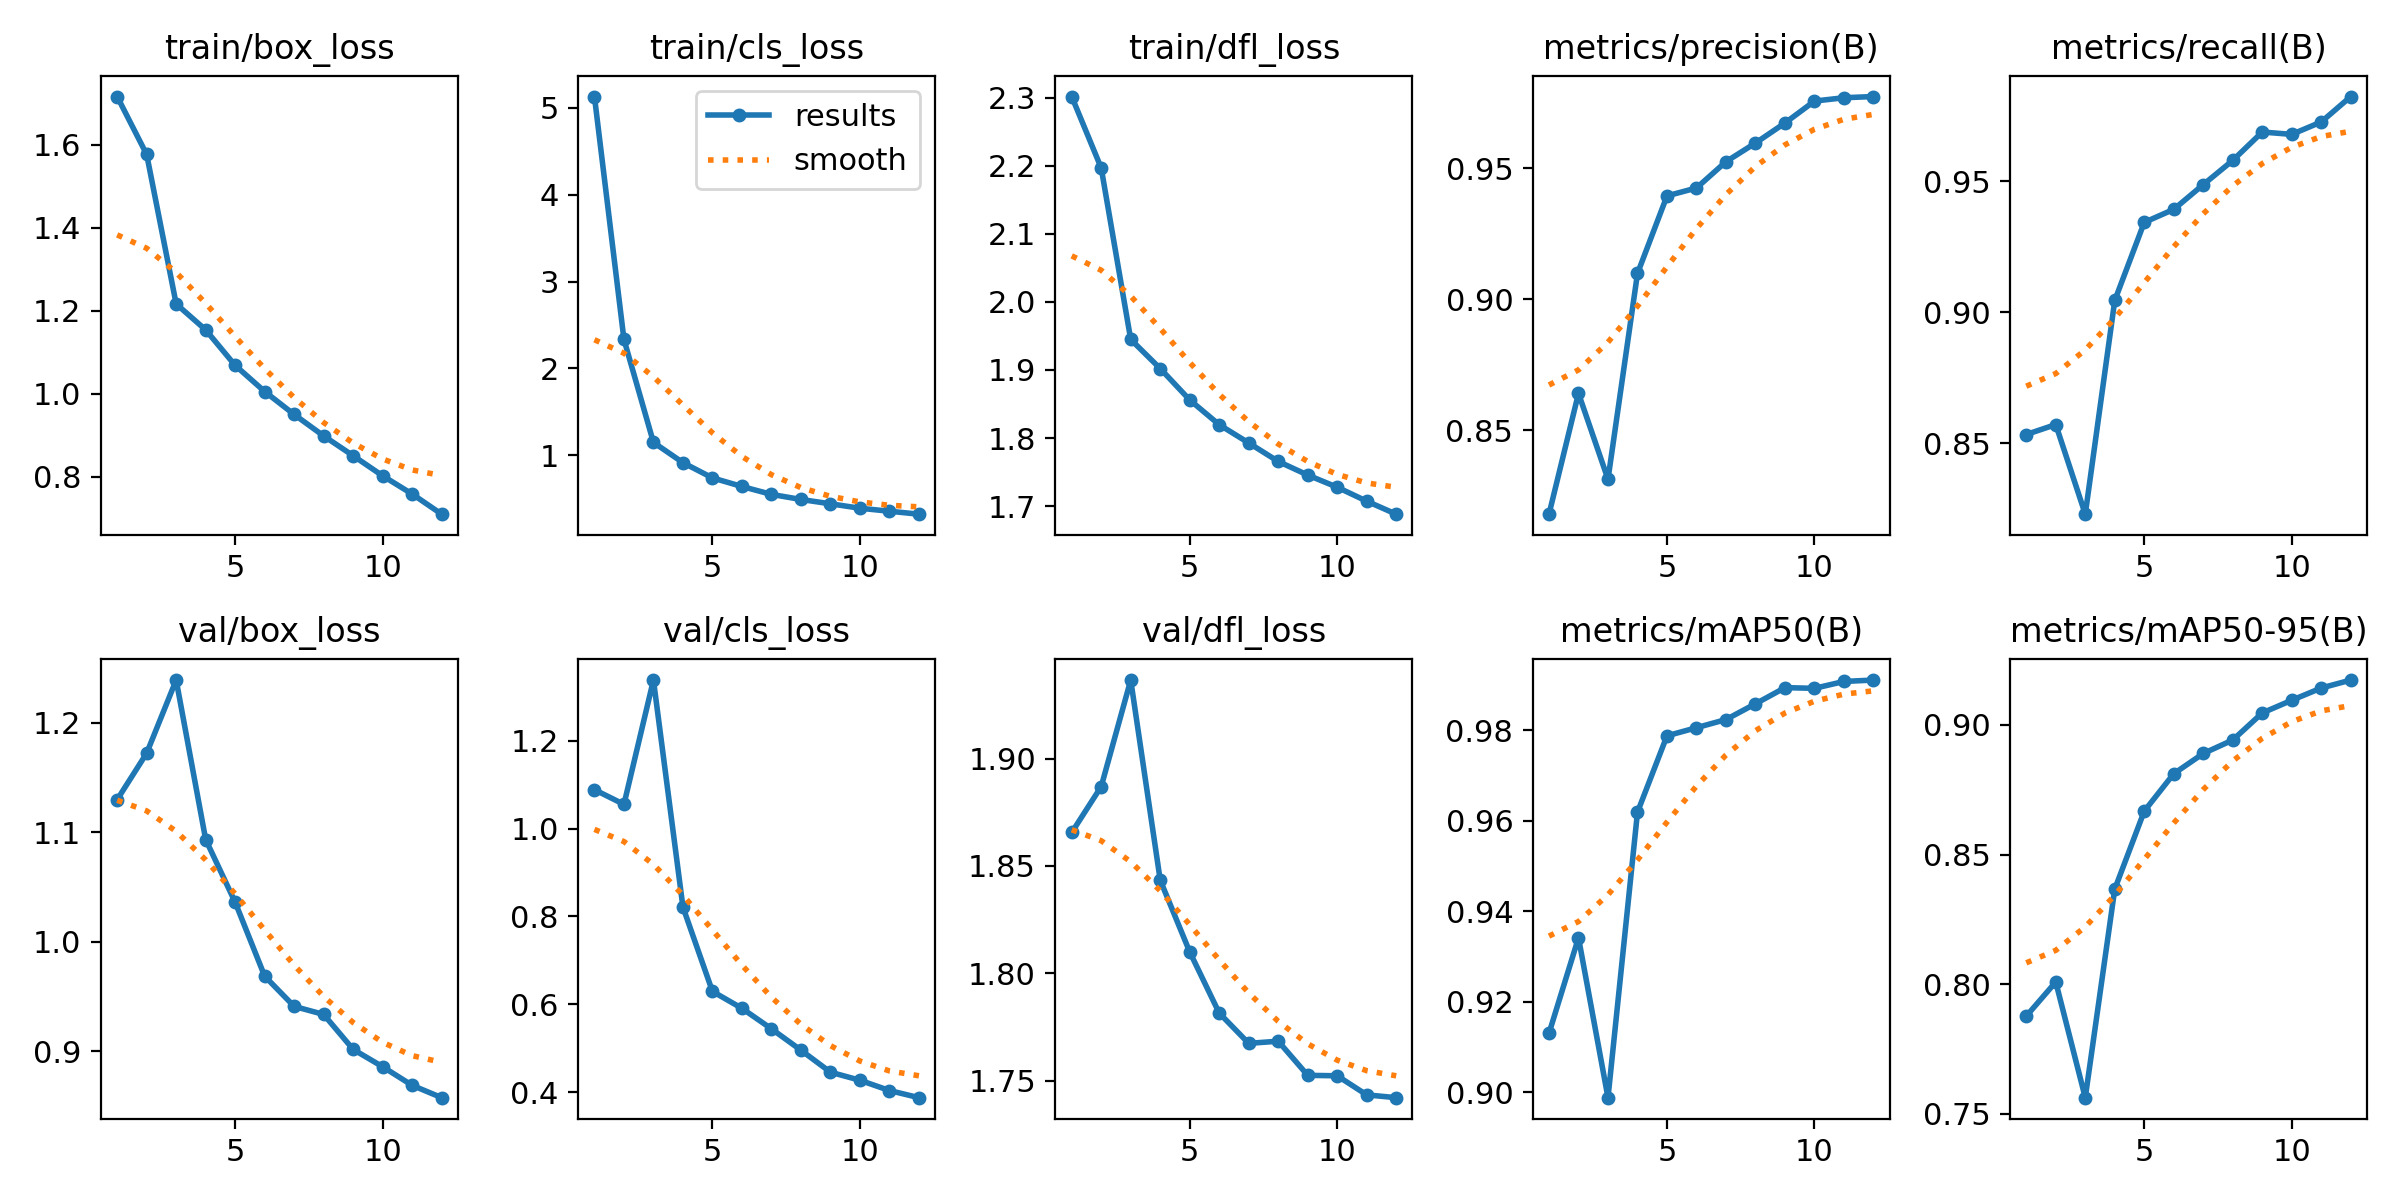

In [36]:
display(Image(filename='/kaggle/working/runs/detect/train/results.png'))


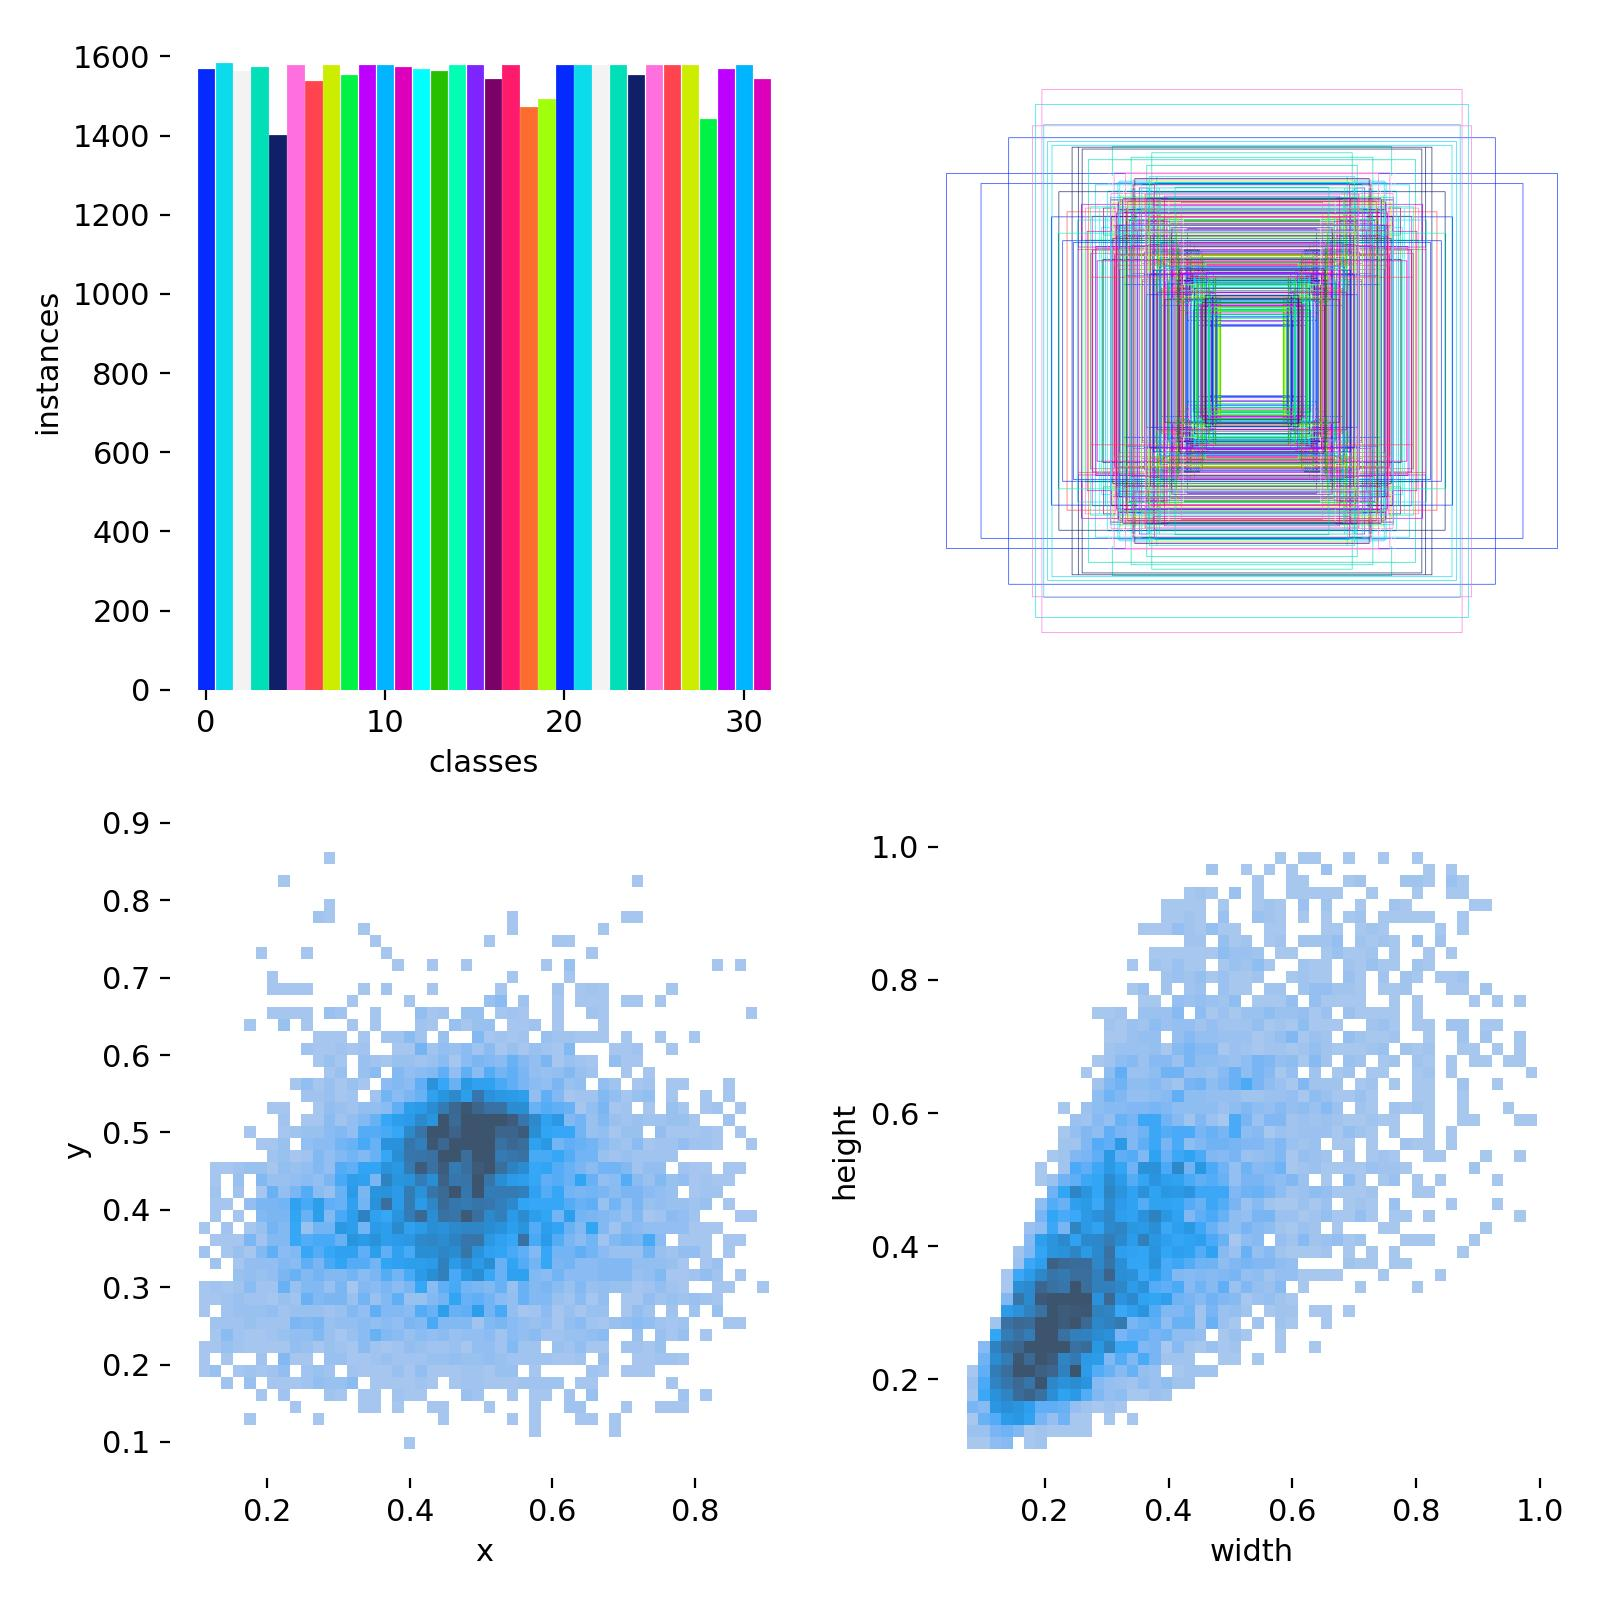

In [37]:
display(Image(filename='/kaggle/working/runs/detect/train/labels.jpg'))

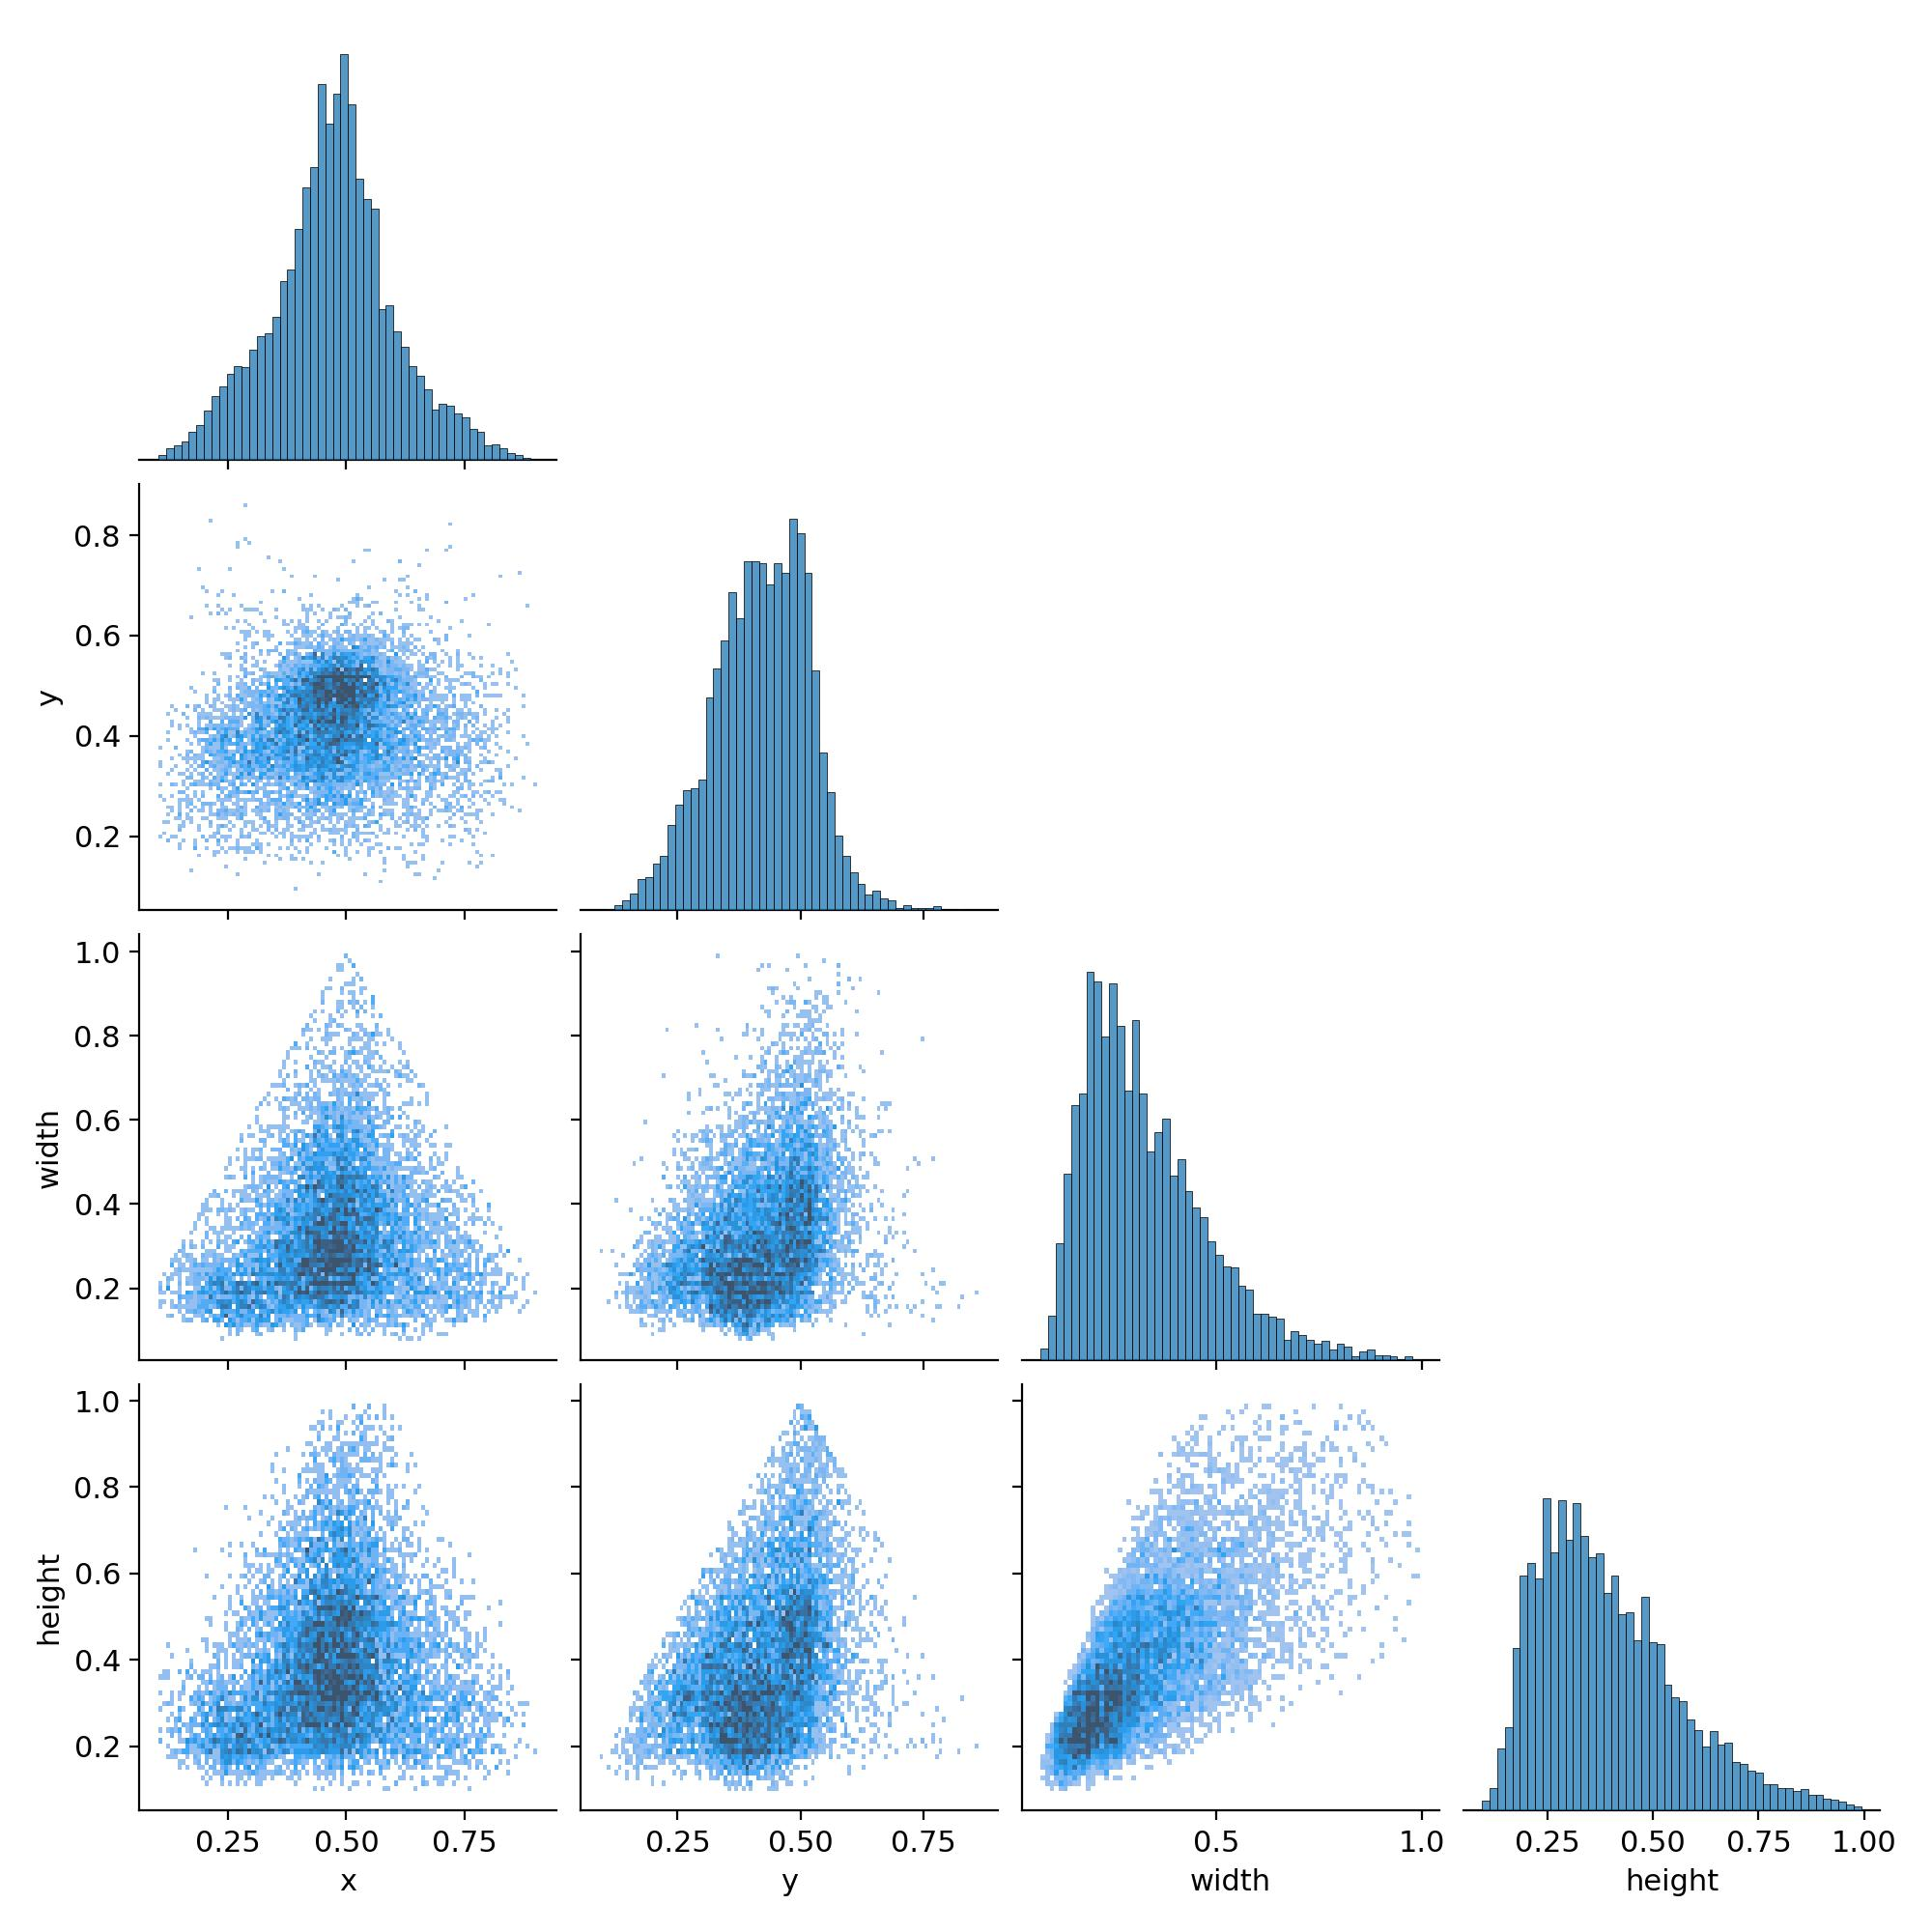

In [38]:
display(Image(filename='/kaggle/working/runs/detect/train/labels_correlogram.jpg'))